In [1]:
def align_and_merge_dataframes(df_dict, fill_method='bfill'):
    """
    Aligns and merges multiple daily DataFrames into a single DataFrame without NaN values.
    Replace NaN with next/previous value in the beginning/end 

    Parameters:
    - df_dict (dict): A dictionary where keys are the desired column names in the merged DataFrame,
                      and values are pandas DataFrames with a DateTimeIndex.
    - fill_method (str): Method to fill NaN values. Options include 'bfill', 'ffill', 'interpolate'.

    Returns:
    - pd.DataFrame: The merged DataFrame containing all aligned data without NaN values.
    """
    if not df_dict:
        raise ValueError("The input dictionary of DataFrames is empty.")

    # Ensure all DataFrames have a DateTimeIndex
    for name, df in df_dict.items():
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(f"The DataFrame for '{name}' does not have a DateTimeIndex.")

    # 1. Determine Global Start and End Dates
    start_date = min(df.index.min() for df in df_dict.values())
    end_date = max(df.index.max() for df in df_dict.values())

    # 2. Create Master Daily Date Range
    master_freq = 'D'
    master_dates = pd.date_range(start=start_date, end=end_date, freq=master_freq)

    # 3. Reindex and Fill Each DataFrame
    filled_dfs = {}
    for name, df in df_dict.items():
        # Reindex to master_dates
        reindexed_df = df.reindex(master_dates)

        # Fill NaNs based on the specified method
        if fill_method == 'bfill':
            filled_df = reindexed_df.bfill()
        elif fill_method == 'ffill':
            filled_df = reindexed_df.ffill()
        elif fill_method == 'interpolate':
            filled_df = reindexed_df.interpolate(method='linear')
        else:
            raise ValueError("fill_method must be 'bfill', 'ffill', or 'interpolate'")

        # After filling, handle remaining NaNs (if any)
        filled_df = filled_df.fillna(method='ffill').fillna(method='bfill')

        filled_dfs[name] = filled_df

    # 4. Merge All DataFrames
    merged_df = pd.concat(filled_dfs.values(), axis=1)
    merged_df.columns = filled_dfs.keys()

    # 5. Verify No NaN Values
    nan_counts = merged_df.isnull().sum()
    if nan_counts.sum() == 0:
        print("Merged DataFrame:")
        print(merged_df)
        print("\nMerged DataFrame successfully created with no NaN values.")
    else:
        print("There are still NaN values in the merged DataFrame:")
        print(merged_df[merged_df.isnull().any(axis=1)])

    return merged_df

In [8]:
import pandas as pd
import numpy as np

def align_and_merge_dataframes(df_dict, fill_method='ffill'):
    """
    Aligns and merges multiple daily DataFrames into a single DataFrame without NaN values.

    Parameters:
    - df_dict (dict): A dictionary where keys are the desired column names in the merged DataFrame,
                      and values are pandas DataFrames with a DateTimeIndex.
    - fill_method (str): Primary method to fill NaN values. Options include 'ffill', 'bfill', 'interpolate'.

    Returns:
    - pd.DataFrame: The merged DataFrame containing all aligned data without NaN values.
    """
    if not df_dict:
        raise ValueError("The input dictionary of DataFrames is empty.")

    # Ensure all DataFrames have a DateTimeIndex
    for name, df in df_dict.items():
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(f"The DataFrame for '{name}' does not have a DateTimeIndex.")

    # 1. Determine Global Start and End Dates
    start_date = min(df.index.min() for df in df_dict.values())
    end_date = max(df.index.max() for df in df_dict.values())

    # 2. Create Master Daily Date Range
    master_freq = 'D'
    master_dates = pd.date_range(start=start_date, end=end_date, freq=master_freq)

    # 3. Reindex and Fill Each DataFrame
    filled_dfs = {}
    for name, df in df_dict.items():
        # Reindex to master_dates
        reindexed_df = df.reindex(master_dates)

        # Fill NaNs based on the specified method
        if fill_method == 'ffill':
            filled_df = reindexed_df.ffill()
        elif fill_method == 'bfill':
            filled_df = reindexed_df.bfill()
        elif fill_method == 'interpolate':
            filled_df = reindexed_df.interpolate(method='linear')
        else:
            raise ValueError("fill_method must be 'ffill', 'bfill', or 'interpolate'")

        # Apply both ffill and bfill to ensure all NaNs are filled
        filled_df = filled_df.ffill().bfill()

        filled_dfs[name] = filled_df

    # 4. Merge All DataFrames
    merged_df = pd.concat(filled_dfs.values(), axis=1)
    merged_df.columns = filled_dfs.keys()

    # 5. Verify No NaN Values
    if merged_df.isnull().values.any():
        print("There are still NaN values in the merged DataFrame:")
        print(merged_df[merged_df.isnull().any(axis=1)])
    else:
        print("Merged DataFrame:")
        print(merged_df)
        print("\nMerged DataFrame successfully created with no NaN values.")

    return merged_df

# Example Usage
if __name__ == "__main__":
    # 1. Create Sample Daily DataFrames with Different DateTimeIndices

    # a. Sales DataFrame with missing dates (e.g., '2023-01-03' and '2023-01-06' have NaNs)
    dates_sales = pd.date_range(start='2023-01-01', end='2023-01-10', freq='D')
    sales_values = [500, 600, np.nan, 700, 800, np.nan, 900, 1000, 1100, 1200]
    df_sales = pd.DataFrame({'sales': sales_values}, index=dates_sales)

    # b. Temperature DataFrame with missing dates (e.g., '2023-01-05' and '2023-01-08' have NaNs)
    dates_temp = pd.date_range(start='2023-01-02', end='2023-01-09', freq='D')
    temperature_values = [22, 23, 24, np.nan, 26, 27, np.nan, 30]
    df_temperature = pd.DataFrame({'temperature': temperature_values}, index=dates_temp)

    # c. Humidity DataFrame with missing dates (e.g., '2023-01-04' and '2023-01-07' have NaNs)
    dates_humidity = pd.date_range(start='2023-01-01', end='2023-01-07', freq='D')
    humidity_values = [80, 82, 83, np.nan, 85, np.nan, 87]
    df_humidity = pd.DataFrame({'humidity': humidity_values}, index=dates_humidity)

    # 2. Create a dictionary of DataFrames
    dfs = {
        'sales': df_sales,
        'temperature': df_temperature,
        'humidity': df_humidity
    }

    # 3. Call the function to merge and fill NaNs
    merged_df = align_and_merge_dataframes(dfs, fill_method='ffill')


Merged DataFrame:
             sales  temperature  humidity
2023-01-01   500.0         22.0      80.0
2023-01-02   600.0         22.0      82.0
2023-01-03   600.0         23.0      83.0
2023-01-04   700.0         24.0      83.0
2023-01-05   800.0         24.0      85.0
2023-01-06   800.0         26.0      85.0
2023-01-07   900.0         27.0      87.0
2023-01-08  1000.0         27.0      87.0
2023-01-09  1100.0         30.0      87.0
2023-01-10  1200.0         30.0      87.0

Merged DataFrame successfully created with no NaN values.


In [9]:
dates_sales

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10'],
              dtype='datetime64[ns]', freq='D')

In [10]:
dates_temps

DatetimeIndex(['2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09'],
              dtype='datetime64[ns]', freq='D')

In [11]:
dates_humidity 

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07'],
              dtype='datetime64[ns]', freq='D')

In [12]:
df_temperature

,temperature
2023-01-02,22.0
2023-01-03,23.0
2023-01-04,24.0
2023-01-05,NaN
2023-01-06,26.0
2023-01-07,27.0
2023-01-08,NaN
2023-01-09,30.0


In [31]:
import pandas as pd
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

# Create a date range with daily frequency for 30 days
date_range = pd.date_range(start='2023-01-01', periods=30, freq='D')

# Simulate daily returns as percentages
returns = np.random.normal(loc=0.001, scale=0.02, size=len(date_range))  # Mean 0.1%, SD 2%

# Simulate regimes: Let's assume three regimes 'A', 'B', 'C' switching every 10 days
regimes = ['A'] * 10 + ['B'] * 10 + ['C'] * 10

# Create the DataFrame
df = pd.DataFrame({
    'timestamp': date_range,
    'returns': returns,
    'regime': regimes
}).set_index('timestamp')

print(df.head())


             returns regime
timestamp                  
2023-01-01  0.010934      A
2023-01-02 -0.001765      A
2023-01-03  0.013954      A
2023-01-04  0.031461      A
2023-01-05 -0.003683      A


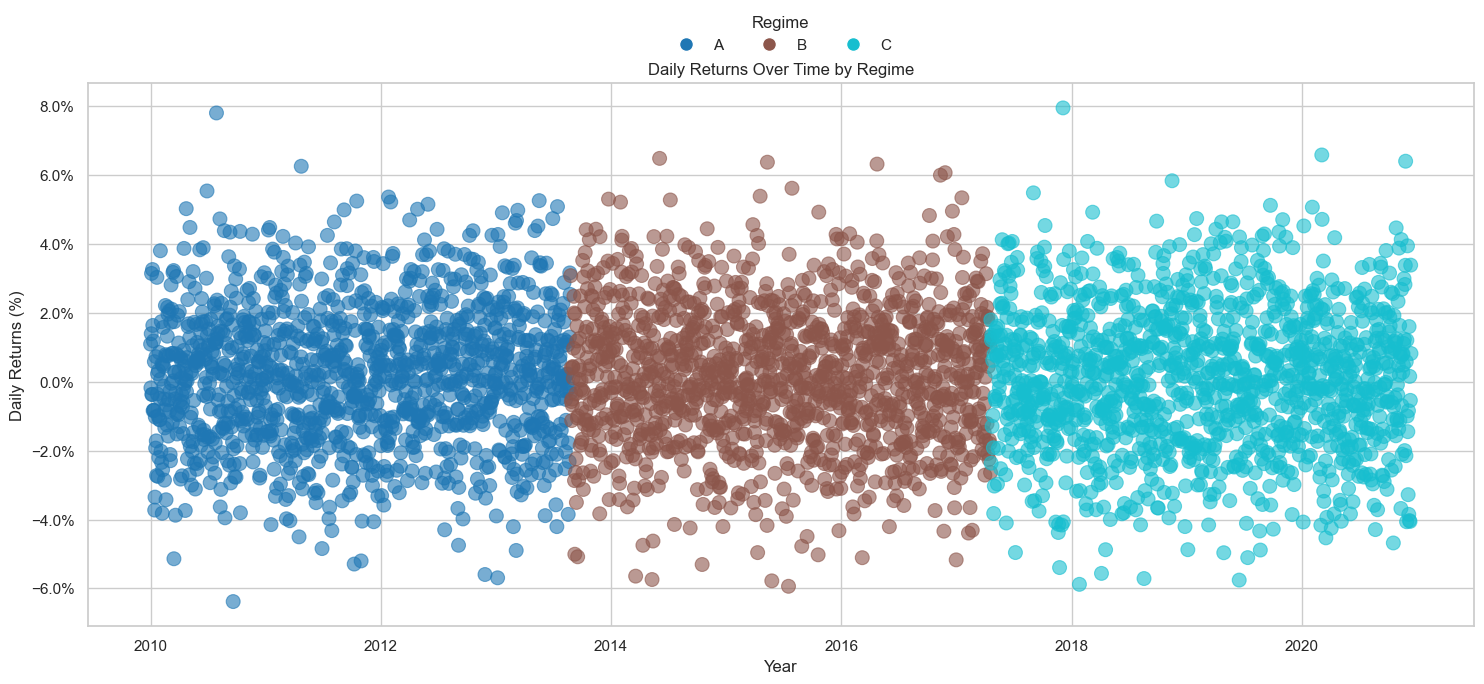


Returns Series for Regime B:
timestamp
2013-08-26    0.030815
2013-08-27    0.003973
2013-08-28   -0.005742
2013-08-29   -0.011268
2013-08-30   -0.005049
Name: returns, dtype: float64


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
import numpy as np

def plot_returns_seaborn(df, time_col='timestamp', return_col='returns', regime_col='regime',
                        regime_colors=None, figsize=(15, 7), alpha=0.6, s=100,
                        year_interval=5):
    """
    Plots daily returns over time using Seaborn, colored by regime.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - time_col (str): Column name for timestamps.
    - return_col (str): Column name for returns.
    - regime_col (str): Column name for regimes.
    - regime_colors (dict): Dictionary mapping regimes to colors. 
                            Example: {'A': 'blue', 'B': 'green', 'C': 'red'}
    - figsize (tuple): Figure size.
    - alpha (float): Transparency level of scatter points.
    - s (int): Size of scatter points.
    - year_interval (int): Interval in years for major x-axis ticks.

    Returns:
    - None: Displays the plot.
    """
    # Reset index to have 'timestamp' as a column if it's the index
    if df.index.name == time_col:
        df_plot = df.reset_index()
    else:
        df_plot = df.copy()
    
    # Validate required columns after resetting index
    required_columns = {time_col, return_col, regime_col}
    if not required_columns.issubset(df_plot.columns):
        missing = required_columns - set(df_plot.columns)
        raise ValueError(f"DataFrame is missing required columns: {missing}")
    
    if regime_colors is None:
        # Default color mapping using the updated colormap access method
        unique_regimes = df_plot[regime_col].unique()
        cmap = plt.colormaps['tab10']
        colors = cmap(np.linspace(0, 1, len(unique_regimes)))
        regime_colors = {regime: colors[i] for i, regime in enumerate(unique_regimes)}
    
    # Convert returns to percentage
    df_plot[return_col] = df_plot[return_col] * 100
    
    # Set the plot style
    sns.set(style="whitegrid")
    
    # Create the scatter plot
    plt.figure(figsize=figsize)
    scatter = sns.scatterplot(data=df_plot, x=time_col, y=return_col, hue=regime_col,
                              palette=regime_colors, s=s, alpha=alpha, edgecolor=None)
    
    # Formatting the y-axis as percentages
    scatter.yaxis.set_major_formatter(PercentFormatter())
    
    # Labels and title
    plt.xlabel('Year')
    plt.ylabel('Daily Returns (%)')
    plt.title('Daily Returns Over Time by Regime')
    
    # Date formatting on x-axis to show years with specified interval
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=year_interval))  # Major ticks every 'year_interval' years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Optionally, set minor ticks for months
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    plt.xticks(rotation=0)
    
    # Custom legend positioned above the plot without a box
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=regime,
                              markerfacecolor=color, markersize=10) 
                       for regime, color in regime_colors.items()]
    
    plt.legend(handles=legend_elements, title='Regime', loc='upper center', 
               bbox_to_anchor=(0.5, 1.15), ncol=len(regime_colors), frameon=False)
    
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    # Sample DataFrame creation spanning multiple years
    np.random.seed(42)
    date_range = pd.date_range(start='2010-01-01', periods=4000, freq='D')  # Approximately 10.95 years
    returns = np.random.normal(loc=0.001, scale=0.02, size=len(date_range))  # Mean 0.1%, SD 2%
    regimes = ['A'] * 1333 + ['B'] * 1333 + ['C'] * 1334  # Approximately equal durations
    
    df = pd.DataFrame({
        'timestamp': date_range,
        'returns': returns,
        'regime': regimes
    }).set_index('timestamp')
    
    # Plot using the updated Seaborn function with yearly ticks every 2 years
    plot_returns_seaborn(df, year_interval=2)
    
    # Extracting regime-wise return series
    regime_returns = extract_regime_series(df, return_col='returns', regime_col='regime')
    
    # Accessing and displaying the returns series for Regime B
    print("\nReturns Series for Regime B:")
    print(regime_returns['B'].head())


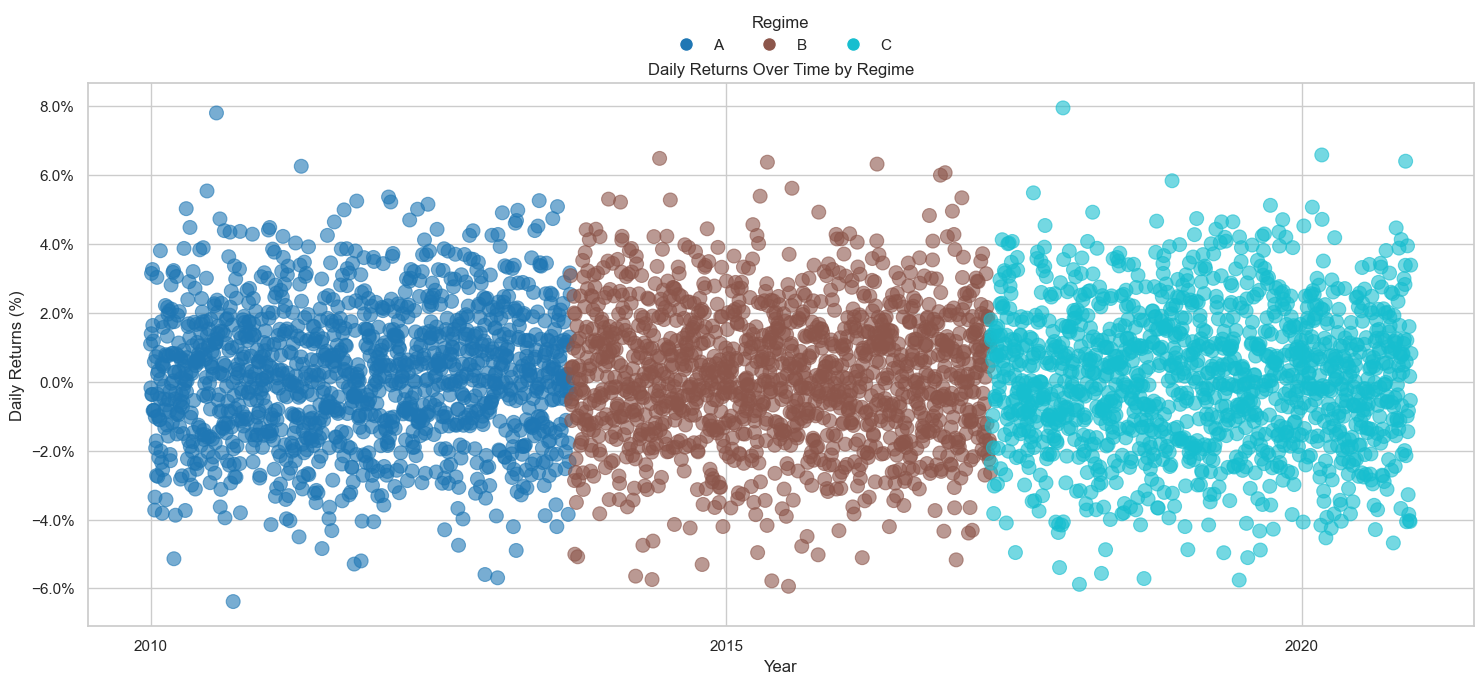

In [45]:
if __name__ == "__main__":
    # Plot using the Seaborn function
    plot_returns_seaborn(df)
